<a href="https://colab.research.google.com/github/Akshat13shah/STT-_Ai_Assignment7/blob/main/Model_Checkpointing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 18

1.  Paras Prashant Shirvale
* Roll Number: 23110232

2. Akshat Shah
* 23110232

GitHub Repository: https://github.com/Akshat13shah/STT-_Ai_Assignment7

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load SST2 Train dataset
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
train_df = pd.read_csv(train_url, sep="\t")  # Tab-separated file

# Load SST2 Test dataset
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"
test_df = pd.read_csv(test_url, sep="\t")  # Tab-separated file

# Split training data into training and validation sets (80% train, 20% validation)
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Load IMDB dataset
imdb_url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"
imdb_df = pd.read_csv(imdb_url)  # CSV file

print("Training data size:", len(train_data))
print("Validation data size:", len(val_data))
print("Test data size:", len(test_df))

Training data size: 5535
Validation data size: 1384
Test data size: 1820


In [2]:
# Assign column names to SST2 datasets if missing
train_data.columns = ['text', 'label']
val_data.columns = ['text', 'label']
test_df.columns = ['text', 'label']

# Ensure labels are integers
train_data['label'] = train_data['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)

In [3]:
# Check IMDB dataset columns
print(imdb_df.columns)  # Should contain 'review' and 'sentiment'

# Convert sentiment labels to numeric (0 = negative, 1 = positive)
imdb_df['sentiment'] = imdb_df['sentiment'].map({'negative': 0, 'positive': 1})

# Split the IMDB dataset into training and validation sets
X_imdb_train, X_imdb_validation, y_imdb_train, y_imdb_validation = train_test_split(imdb_df['review'], imdb_df['sentiment'], test_size=0.2, random_state=20)

Index(['review', 'sentiment'], dtype='object')


In [4]:
print("Missing values in SST2 Train:", train_data.isnull().sum())
print("Missing values in SST2 Test:", test_df.isnull().sum())
print("Missing values in IMDB:", imdb_df.isnull().sum())

Missing values in SST2 Train: text     0
label    0
dtype: int64
Missing values in SST2 Test: text     0
label    0
dtype: int64
Missing values in IMDB: review       0
sentiment    0
dtype: int64


In [5]:
print("SST2 Train Label Distribution:\n", train_data['label'].value_counts())
print("SST2 Test Label Distribution:\n", test_df['label'].value_counts())
print("IMDB Sentiment Distribution:\n", imdb_df['sentiment'].value_counts())

SST2 Train Label Distribution:
 label
1    2878
0    2657
Name: count, dtype: int64
SST2 Test Label Distribution:
 label
0    911
1    909
Name: count, dtype: int64
IMDB Sentiment Distribution:
 sentiment
1    25000
0    25000
Name: count, dtype: int64


In [6]:
train_data.head()

,text,label
26,too bad,0
3484,rife with nutty cliches and far too much dialogue,0
63,admirers of director abel ferrara may be relie...,1
1044,"the enjoyable undercover brother , a zany mix ...",1
2594,knockaround guys plays like a student film by ...,0


In [7]:
test_df.head()

,text,label
0,"a gob of drivel so sickly sweet , even the eag...",0
1,"gangs of new york is an unapologetic mess , wh...",0
2,"we never really feel involved with the story ,...",0
3,this is one of polanski 's best films,1
4,take care of my cat offers a refreshingly diff...,1


In [8]:
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [9]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout_rate))

        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))

        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Initialize the model
input_size = 10000
hidden_sizes = [512, 256, 128, 64]
output_size = 2
model = MLP(input_size, hidden_sizes, output_size)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters:", total_params)
print(model)

Total trainable parameters: 5293122
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [10]:
%pip install torchsummary

In [11]:
from torchsummary import summary
summary(model, (1,10000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]       5,120,512
              ReLU-2               [-1, 1, 512]               0
           Dropout-3               [-1, 1, 512]               0
            Linear-4               [-1, 1, 256]         131,328
              ReLU-5               [-1, 1, 256]               0
           Dropout-6               [-1, 1, 256]               0
            Linear-7               [-1, 1, 128]          32,896
              ReLU-8               [-1, 1, 128]               0
           Dropout-9               [-1, 1, 128]               0
           Linear-10                [-1, 1, 64]           8,256
             ReLU-11                [-1, 1, 64]               0
          Dropout-12                [-1, 1, 64]               0
           Linear-13                 [-1, 1, 2]             130
Total params: 5,293,122
Trainable param

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=10000)

# Fit and transform the training data
X_train = vectorizer.fit_transform(train_data['text'])  # Replace 'text' with the column name containing text
X_val = vectorizer.transform(val_data['text'])
X_test = vectorizer.transform(test_df['text'])

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_val = torch.tensor(X_val.toarray(), dtype=torch.float32)
X_test = torch.tensor(X_test.toarray(), dtype=torch.float32)

# Labels (assuming binary classification)
y_train = torch.tensor(train_data['label'].values, dtype=torch.long)
y_val = torch.tensor(val_data['label'].values, dtype=torch.long)
y_test = torch.tensor(test_df['label'].values, dtype=torch.long)

In [13]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        _, predicted = torch.max(val_outputs, 1)
        val_accuracy = (predicted == y_val).sum().item() / len(y_val)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy}")

Epoch 1/10, Loss: 0.6987206935882568, Validation Loss: 0.6993170976638794, Validation Accuracy: 0.4718208092485549
Epoch 2/10, Loss: 0.6980841755867004, Validation Loss: 0.699146568775177, Validation Accuracy: 0.4718208092485549
Epoch 3/10, Loss: 0.6982191801071167, Validation Loss: 0.6989765167236328, Validation Accuracy: 0.4718208092485549
Epoch 4/10, Loss: 0.6978186964988708, Validation Loss: 0.6988053321838379, Validation Accuracy: 0.4718208092485549
Epoch 5/10, Loss: 0.6976679563522339, Validation Loss: 0.6986328363418579, Validation Accuracy: 0.4718208092485549
Epoch 6/10, Loss: 0.697573184967041, Validation Loss: 0.6984584927558899, Validation Accuracy: 0.4718208092485549
Epoch 7/10, Loss: 0.6971011161804199, Validation Loss: 0.698282778263092, Validation Accuracy: 0.4718208092485549
Epoch 8/10, Loss: 0.6972414255142212, Validation Loss: 0.6981062889099121, Validation Accuracy: 0.4718208092485549
Epoch 9/10, Loss: 0.6968798637390137, Validation Loss: 0.6979277729988098, Validati

In [ ]:
import gzip
import pickle

def save_checkpoint(model, path="checkpoint.pt.gz"):
    checkpoint = {
        "model_state_dict": model.state_dict()
    }
    with gzip.open(path, 'wb') as f:
        pickle.dump(checkpoint, f)
    print(f"Model weights saved successfully to {path}")

save_checkpoint(model)

In [14]:
# Fit and transform the training data
X_imdb_train = vectorizer.fit_transform(X_imdb_train)  # Replace 'text' with the column name containing text
X_imdb_validation = vectorizer.transform(X_imdb_validation)

# Convert to PyTorch tensors
X_imdb_train = torch.tensor(X_imdb_train.toarray(), dtype=torch.float32)
X_imdb_validation = torch.tensor(X_imdb_validation.toarray(), dtype=torch.float32)

# Labels (assuming binary classification)
y_imdb_train = torch.tensor(y_imdb_train.values, dtype=torch.long)
y_imdb_validation = torch.tensor(y_imdb_validation.values, dtype=torch.long)

In [ ]:
# Load the checkpoint
def load_checkpoint(model, path="checkpoint.pt.gz"):
    with gzip.open(path, 'rb') as f:
        checkpoint = pickle.load(f)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Model weights loaded successfully from {path}")

load_checkpoint(model)

In [20]:
# Initialize the model
input_size = 10000
hidden_sizes = [512, 256, 128, 64]
output_size = 2
model = MLP(input_size, hidden_sizes, output_size)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters:", total_params)
print(model)

Total trainable parameters: 5293122
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [21]:
# Training loop for IMDB dataset
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_imdb_train)
    loss = criterion(outputs, y_imdb_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_imdb_validation)
        val_loss = criterion(val_outputs, y_imdb_validation)
        _, predicted = torch.max(val_outputs, 1)
        val_accuracy = (predicted == y_imdb_validation).sum().item() / len(y_imdb_validation)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy}")

Epoch 1/10, Loss: 0.6932908892631531, Validation Loss: 0.6930071711540222, Validation Accuracy: 0.5072
Epoch 2/10, Loss: 0.6933997869491577, Validation Loss: 0.6930071711540222, Validation Accuracy: 0.5072
Epoch 3/10, Loss: 0.693420946598053, Validation Loss: 0.6930071711540222, Validation Accuracy: 0.5072
Epoch 4/10, Loss: 0.6933696269989014, Validation Loss: 0.6930071711540222, Validation Accuracy: 0.5072
Epoch 5/10, Loss: 0.6933701634407043, Validation Loss: 0.6930071711540222, Validation Accuracy: 0.5072
Epoch 6/10, Loss: 0.6934787631034851, Validation Loss: 0.6930071711540222, Validation Accuracy: 0.5072
Epoch 7/10, Loss: 0.6933287382125854, Validation Loss: 0.6930071711540222, Validation Accuracy: 0.5072
Epoch 8/10, Loss: 0.6933574080467224, Validation Loss: 0.6930071711540222, Validation Accuracy: 0.5072
Epoch 9/10, Loss: 0.693378746509552, Validation Loss: 0.6930071711540222, Validation Accuracy: 0.5072
Epoch 10/10, Loss: 0.6933541893959045, Validation Loss: 0.6930071711540222,

In [16]:
model.eval()
with torch.no_grad():
    val_outputs = model(X_imdb_validation)
    val_loss = criterion(val_outputs, y_imdb_validation)
    _, predicted = torch.max(val_outputs, 1)
    val_accuracy = (predicted == y_imdb_validation).sum().item() / len(y_imdb_validation)

print(f"Final Validation Loss: {val_loss.item()}, Final Validation Accuracy: {val_accuracy}")

Final Validation Loss: 0.6859850883483887, Final Validation Accuracy: 0.5671


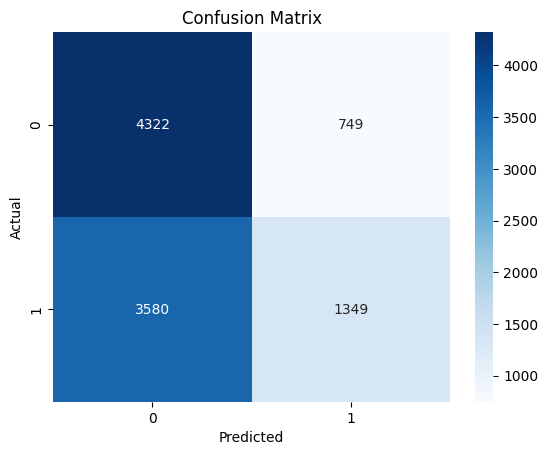

Accuracy: 0.5671
Precision: 0.6429933269780743
Recall: 0.2736863461148306
F1 Score: 0.3839476305678099


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion Matrix
cm = confusion_matrix(y_imdb_validation, predicted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Evaluation Metrics
accuracy = accuracy_score(y_imdb_validation, predicted)
precision = precision_score(y_imdb_validation, predicted)
recall = recall_score(y_imdb_validation, predicted)
f1 = f1_score(y_imdb_validation, predicted)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install huggingface_hub

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
print("cuda" if torch.cuda.is_available() else "cpu")

cpu


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load tokenizer and model
model_name = "meta-llama/Llama-3.1-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Function to get embeddings
def get_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu()

# Get embeddings for training, validation, and test data
X_train_emb = get_embeddings(train_data['text'].tolist())
X_val_emb = get_embeddings(val_data['text'].tolist())
X_test_emb = get_embeddings(test_df['text'].tolist())

Trying to resume download...


KeyboardInterrupt: 